# MTG Deck builder

In [1]:
from langchain_ollama import ChatOllama, OllamaEmbeddings

llm = ChatOllama(model="qwen2.5:32b", num_ctx=8192)
embeddings = OllamaEmbeddings(model="snowflake-arctic-embed2")

In [2]:
from deep_mtg.tools import RulesRetriever, CardsRetriever

In [3]:
from pathlib import Path

cards_retriever = CardsRetriever(Path('../data/cards'), llm=llm, embeddings=embeddings)

Loading vectors from disk ../data/cards/cards.vec...


In [51]:
rules_retriever = RulesRetriever(Path('../data/MagicCompRules 20241108.pdf'), embeddings=embeddings)

Loading vectors from disk ../data/rules.vec...


In [52]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
import operator
from typing import Annotated, List, Literal, TypedDict, Optional

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel, Field
import json

# class Card(BaseModel):
#     name: str = Field(description="Card name")
#     # type: Annotated[str, ..., "Card type"]
#     cost: Optional[str|int] = Field(default=None, description="Card cost, if applicable")
#     text: Optional[str] = Field(default=None, description="Card text, if applicable")
#     power: Optional[str|int] = Field(default=None, description="Card power, if applicable")
#     toughness: Optional[str|int] = Field(default=None, description="Card toughness, if applicable")

# class DeckState(BaseModel):
#     prompt: str = Field(description="Prompt for the deck")
#     cards: list[Card] = Field(description="List of cards in the deck")
#     n_cards: int = Field(description="Number of cards in the deck")
#     # n_lands: Annotated[int, 0, "Number of lands in the deck"]
#     # n_creatures: Annotated[int, 0, "Number of creatures in the deck"]
#     # n_other: Annotated[int, 0, "Number of other cards in the deck"]

class DeckCard(TypedDict):
    name: Annotated[str, ..., "Card name"]
    types: Annotated[str, ..., "Card type"]
    cost: Annotated[Optional[str], ..., "Card cost, including mana colors, if applicable"]
    text: Annotated[Optional[str], ..., "Card text, if applicable"]
    power: Annotated[Optional[int], ..., "Card power, if applicable"]
    toughness: Annotated[Optional[int], ..., "Card toughness, if applicable"]
    description: Annotated[str, ..., "High-level card description"]

# class QueryCard(TypedDict):
#     colours: Annotated[Optional[str], ..., "Mana colours of the card, if applicable"]
#     convertedManaCost: Annotated[int, ..., "Converted mana cost of the card, if applicable"]
#     keywords: Annotated[Optional[list[str]], ..., "List of keywords of the card, if applicable"]
#     manaCost: Annotated[str, ..., "Mana cost of the card, including colours, if applicable"]
#     name: Annotated[str, ..., "Card name"]
#     power: Annotated[int, ..., "Card power, if applicable"]
#     rarity: Annotated[str, ..., "Card rarity [Common, Uncommon, Rare, Mythic Rare]"]
#     subtypes: Annotated[Optional[list[str]], ..., "List of subtypes of the card, if applicable"]
#     text: Annotated[str, ..., "Card text, if applicable"]
#     toughness: Annotated[int, ..., "Card toughness, if applicable"]
#     types: Annotated[str, ..., "Card type"]

class DeckState(TypedDict):
    prompt: Annotated[str, ..., "Deck theme prompt"]
    cards: Annotated[list[DeckCard], [], "List of cards in the deck"]
    n_cards: Annotated[int, 0, "Number of cards in the deck"]
    n_lands: Annotated[int, 0, "Number of lands in the deck"]
    n_creatures: Annotated[int, 0, "Number of creatures in the deck"]
    n_enchantments: Annotated[int, 0, "Number of enchantments in the deck"]
    n_instants: Annotated[int, 0, "Number of instants in the deck"]
    n_sorceries: Annotated[int, 0, "Number of sorceries in the deck"]
    n_artifacts: Annotated[int, 0, "Number of artifacts in the deck"]
    n_other: Annotated[int, 0, "Number of other cards in the deck"]
    current_analysis: Annotated[str, "", "Expert analysis of the current strengths and weaknesses of the deck"]

In [53]:
card_tools_llm = llm.bind_tools([rules_retriever, cards_retriever])
card_advisor_llm = llm

In [54]:
from tqdm import tqdm
from collections import defaultdict

def append_card(deck_state: DeckState, card: DeckCard, with_analysis:bool=True) -> DeckState:
    deck_state['cards'].append(card)
    deck_state['n_cards'] += 1
    if 'land' in card['types'] or 'Land' in card['types']:
        deck_state['n_lands'] += 1
    elif 'creature' in card['types'] or 'Creature' in card['types']:
        deck_state['n_creatures'] += 1
    elif 'enchantment' in card['types'] or 'Enchantment' in card['types']:
        deck_state['n_enchantments'] += 1
    elif 'instant' in card['types'] or 'Instant' in card['types']:
        deck_state['n_instants'] += 1
    elif 'sorcery' in card['types'] or 'Sorcery' in card['types']:
        deck_state['n_sorceries'] += 1
    elif 'artifact' in card['types'] or 'Artifact' in card['types']:
        deck_state['n_artifacts'] += 1
    else:
        deck_state['n_other'] += 1

    deck_analysis_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "Given the current state of the deck, provide an analysis of the current stregths and weaknesses of the deck. "
                "Along with possible strategies that could be built or reinforced. "
                "The deck may not be complete, but eventually it will contain 60 cards. "
                "Your expert analysis will be used to guide the next steps in building the deck. "
                "Do not output the names of cards to be added, your role is simple to provide an analysis of the current deck. "
            ),
            (
                "user",
                "The deck theme is {prompt}. "
                "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "The cards present are:\n{deck}.\n "
                "Please give a think about what are the current strengths and weaknesses of the deck. "
            ),
        ]
    )

    if with_analysis:
        deck_state['current_analysis'] = llm.invoke(deck_analysis_prompt.invoke({"prompt": deck_state['prompt'], "n_cards": deck_state['n_cards'], "n_lands": deck_state['n_lands'], "n_creatures": deck_state['n_creatures'],
                                                                                      "n_other": deck_state['n_other'], "deck": get_deck_list(deck_state)[1]})).content
    else:
        deck_state['current_analysis'] = ''
    return deck_state

def build_deck(deck_state: DeckState) -> DeckState:
    deck_state = build_initial_manabase(deck_state, n=18)
    for _ in tqdm(range(60-24)):
        deck_state = add_card(deck_state)
    deck_state = build_final_manabase(deck_state)
    for _ in tqdm(range(60-deck_state['n_cards'])):
        deck_state = add_card(deck_state)
    return deck_state

class LandSelector(TypedDict):
    n_green: Annotated[int, ..., "Number of basic green lands to add"]
    n_blue: Annotated[int, ..., "Number of basic blue lands to add"]
    n_red: Annotated[int, ..., "Number of basic red lands to add"]
    n_white: Annotated[int, ..., "Number of basic white lands to add"]
    n_black: Annotated[int, ..., "Number of basic black lands to add"]
    n_green_white: Annotated[int, ..., "Number of green-white dual lands to add"]
    n_blue_white: Annotated[int, ..., "Number of blue-white dual lands to add"]
    n_black_white: Annotated[int, ..., "Number of black-white dual lands to add"]
    n_red_white: Annotated[int, ..., "Number of red-white dual lands to add"]
    n_green_blue: Annotated[int, ..., "Number of green-blue dual lands to add"]
    n_black_blue: Annotated[int, ..., "Number of black-blue dual lands to add"]
    n_red_blue: Annotated[int, ..., "Number of red-blue dual lands to add"]
    n_green_black: Annotated[int, ..., "Number of green-black dual lands to add"]
    n_red_black: Annotated[int, ..., "Number of red-black dual lands to add"]

land_selector_llm = llm.with_structured_output(LandSelector)

def build_initial_manabase(deck_state: DeckState, n: int) -> DeckState:
    prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "You are working with a fellow expert deck builder to build a deck. "
                "Your role is to suggest the best combination of lands to form the initial manabase of the deck. "
                "You should add a total of {n_lands} lands to the deck. "
                "These can be basic lands or dual lands. "
                "Since you will be providing the initial manabase, you should consider the colour requirements of the deck given the theme. "
                "Your colleague will then add the remaining cards to the deck, after which you will be able to finalise the manabase of the deck. "
                "If no lands of a particular type are needed, you should output 0 for that type. "
                "Remeber that the more colors you add to the deck, the more dual lands you should include. "
                "When choosing which colors to include, consider the trade-off between ease of play of and card variety: more colors allow for more card variety, but make the deck harder to play. "
                "Think very carefully about the manabase, and do not add colors haphazardly. "
            ),
            (
                "user",
                "The deck theme is {prompt}. "
                "Please output how lands of each type I should add. "
            ),
        ]
    )

    backup_prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "You are working with a fellow expert deck builder to build a deck. "
                "Your role is to suggest the best combination of mana colors to form the initial manabase of the deck given the theme. "
                "You should only output the mana colors, and not any other information. "
                "\n"
                "Examples:\n"
                "- life-gain vampires: black and white\n"
                "- goblin tribal: red\n"
                "- Azorius control: blue and white\n"
                "- mono-green elves: green\n"
                "- Rakdos sacrifice: black and red\n"
                "- Izzet spells: blue and red\n"
                "- Grixis control: blue, black, and red\n"
                "- Sultai midrange: black, green, and blue\n"
                "- Jeskai control: blue, white, and red\n"
            ),
            (
                "user",
                "The deck theme is {prompt}. "
                "Please output the mana colors I should use. "
            ),
        ]
    )

    response = None
    fails = 0
    while response is None:
        if fails > 5:
            print('Failed to correctly output the initial manabase after 5 attempts, relaxing constraints')
            n_colors = 0
            while n_colors == 0:
                backup_response = llm.invoke(backup_prompt_template.invoke({"prompt": deck_state['prompt'],"n_lands": n})).content.lower()
                colors = []
                for color in ['green', 'red', 'black', 'blue', 'white']:
                    if color in backup_response:
                        colors.append(color)
                n_colors = len(colors)
            
            response = LandSelector(n_green=0, n_blue=0, n_red=0, n_white=0, n_black=0, n_green_white=0, n_blue_white=0, n_black_white=0, n_red_white=0, n_green_blue=0, n_black_blue=0, n_red_blue=0, n_green_black=0, n_red_black=0, n_other=0)     
            if n_colors == 1:
                n_each = n
                n_duals = 0
            else:
                n_duals = 3
                n_each = (n-n_duals) // n_colors

            for i in range(n_colors):
                response[f'n_{colors[i]}'] = n_each
                for j in range(i+1, n_colors):
                    response[f'n_{colors[i]}_{colors[j]}'] = n_duals         
            break

        response = land_selector_llm.invoke(prompt_template.invoke({"prompt": deck_state['prompt'], "n_lands": n}))
        fails += 1

    print('Initial manabase:', response)
    for count in response:
        land = count[2:]
        for _ in range(response[count]):
            deck_state = append_card(deck_state,
                                     DeckCard(name=f'{land} land', types=['land'], cost=None, text=f'{land} land', power=0, toughness=0, description=f'{land} land'),
                                     with_analysis=False)

    return deck_state

class NLandsResponse(TypedDict):
    n_lands: Annotated[int, ..., "Number of lands to add"]

n_lands_llm = llm.with_structured_output(NLandsResponse)
    
def build_final_manabase(deck_state: DeckState) -> DeckState:
    n_lands_query_prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "You are working with a fellow expert deck builder to build a deck. "
                "They have put together a deck with a total of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "Your role is to finalize manabase of the deck by suggesting how many more lands should be added. "
                "To do this, you should consider the current state of the deck, the metagame, and the deck theme. "
                "Most 60-card decks run between 20 and 26 lands, with 24 being standard. "
                "However, the exact number of lands can vary depending on the deck's theme and strategy. "
                "Cheaper, faster decks may run fewer lands, while slower, more expensive decks may run more lands. "
                "Remaining slots after adding the number of lands you suggest will be filled with other cards. "
            ),
            (
               "user",
                "The deck theme is {prompt}. "
                "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "The cards present are:\n{deck}.\n "
                "Please suggest how many more lands should be added. "
            ),
        ]
    )
    
    n_remaining_lands = None
    fails = 0
    while n_remaining_lands is None:
        if fails > 5:
            print('Failed to correctly output the number of lands after 5 attempts, setting total lands to 24')
            n_remaining_lands = 24-deck_state['n_lands']
            break
        response = n_lands_llm.invoke(n_lands_query_prompt_template.invoke({"prompt": deck_state['prompt'], "n_cards": deck_state['n_cards'], "n_lands": deck_state['n_lands'], "n_creatures": deck_state['n_creatures'],
                                                                                      "n_other": deck_state['n_other'], "deck": get_deck_list(deck_state)[1]}))
        if response is not None:
            n_remaining_lands = response['n_lands']
        if n_remaining_lands < 0 or n_remaining_lands > 60-deck_state['n_cards']:
            n_remaining_lands = None
        fails += 1

    print('Number of lands to add:', n_remaining_lands)

    land_query_prompt_template = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "You are working with a fellow expert deck builder to build a deck. "
                "They have put together a prototype deck, and your role is to finalize manabase of the deck by incrementally adding lands. "
                "You will do this by describing the next land to be added to the deck. "
                "The desired card doesn't need to actually exist in the game, I will find the closest card that matches your description. "
                "\n"
                "Example descriptions: "
                '\nA dual land that taps for green and white mana and can be used to fix your mana base'
                '\nA land that can produce creature tokens'
                '\nA land that can be sacrificed to search for another card'
                '\nA land can attack and block like a creature'
                "\n"
                "Only describe one card at a time. "
                "Do not return anything other than the description of the card. "
                "Do not mention the name of the card or the theme of the deck. "
                "Please also describe its role in the deck. "
                "Rather than quantifying attributes of the card, instead use qualitative terms like 'strong' or 'weak' to describe the card. "
                "\n"
                "When choosing the card, consider the following: "
                "\n1. The card should be a good fit for the deck theme. "
                "\n2. The card should be a good fit for the current state of the deck. "
                "\n3. The card should be a good fit for the current metagame. "
                "\n4. What is the card's role in the deck? "
                "\n5. What is the card's impact on the game? "
                "\n6. What is the card's synergy with other cards in the deck? "
                "\n7. What is the card's synergy with the deck's strategy? "
                "\n8. What current weaknesses in the deck does the card address? "
                "\n9. What current strengths in the deck does the card enhance? "
            ),
            (
               "user",
                "The deck theme is {prompt}. "
                "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "The cards present are:\n{deck}.\n "
                "In total, you will be able to add in {n_remaining_lands} more lands to the deck, inclduing this one. "
                "Please give a description of what land card should be added to the deck. "
            ),
        ]
    )

    for _ in tqdm(range(n_remaining_lands)):
        desired_card = llm.invoke(land_query_prompt_template.invoke({"prompt": deck_state['prompt'], "n_cards": deck_state['n_cards'], "n_lands": deck_state['n_lands'], "n_creatures": deck_state['n_creatures'], "n_other": deck_state['n_other'], 
                                                                     "deck": get_deck_list(deck_state)[1], 
                                                                "n_remaining_lands": n_remaining_lands})).content
        print('Recommended card:', desired_card)
        card = search_card(deck_state, desired_card)
        deck_state = append_card(deck_state, card)
        n_remaining_lands -= 1

    return deck_state


def get_deck_list(deck_state: DeckState) -> tuple[dict[dict[str, int]], str]:
    deck_contents = defaultdict(lambda: defaultdict(int))
    type_counts = defaultdict(int)
    production:list[str] = []
    requirements:list[str] = []

    for card in deck_state['cards']:
        entry = f"{card['name']}: {card['description']}"
        types = ','.join(card['types']).lower()

        if card['cost'] is not None:
            if '{B}' in card['cost']:
                requirements.append('black')
            if '{U}' in card['cost']:
                requirements.append('blue')
            if '{R}' in card['cost']:
                requirements.append('red')
            if '{W}' in card['cost']:
                requirements.append('white')
            if '{G}' in card['cost']:
                requirements.append('green')    

        if 'land' in types:
            if '{B}' in card['text'] or 'black' in card['name'].lower():
                production.append('black')
            if '{U}' in card['text'] or 'blue' in card['name'].lower():
                production.append('blue')
            if '{R}' in card['text'] or 'red' in card['name'].lower():
                production.append('red')
            if '{W}' in card['text'] or 'white' in card['name'].lower():
                production.append('white')
            if '{G}' in card['text'] or 'green' in card['name'].lower():
                production.append('green')
            deck_contents['lands'][entry] += 1
            type_counts['lands'] += 1
        elif 'creature' in types:
            deck_contents['creatures'][entry] += 1
            type_counts['creatures'] += 1
            
        elif 'sorcery' in types:
            deck_contents['sorceries'][entry] += 1
            type_counts['sorceries'] += 1
        elif 'instant' in types:
            deck_contents['instants'][entry] += 1
            type_counts['instants'] += 1
        elif 'enchantment' in types:
            deck_contents['enchantments'][entry] += 1
            type_counts['enchantments'] += 1
        elif 'artifact' in types:
            deck_contents['artifacts'][entry] += 1
            type_counts['artifacts'] += 1
        else:
            deck_contents['other'][entry] += 1
            type_counts['other'] += 1
        
    requirements = list(set(requirements))
    production = list(set(production))
    
    deck_str = ''
    for card_type, cards in deck_contents.items():
        deck_str += f'\n## {card_type}: {type_counts[card_type]}'
        for card, count in cards.items():
            deck_str += f'\n- {count} x {card}'
    deck_str += '\n'
    deck_str += f'\n## Mana production: {' '.join(production)}'
    deck_str += f'\n## Mana requirements: {' '.join(requirements)}\n'

    return deck_contents, deck_str

def add_card(deck_state: DeckState) -> DeckState:
    prompt = deck_state['prompt']
    if deck_state['n_cards'] == 0:
        prompt = prompt + ' but it is currently empty'

    deck_contents, deck_str = get_deck_list(deck_state)
    print('Current deck:', deck_str)

    card_advisor_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "Given the current state of the deck, provide a high-level description of what card should be added next. "
                "If the deck is empty, suggest a starting card that would be a good fit for the theme. "
                "The desired card doesn't need to actually exist in the game, I will find the closest card that matches your description. "
                "\n"
                "Example descriptions: "
                '\nA cheap, weak, red creature with flying and haste that can be played early in the game'
                '\nA 3-4 mana white sorcery that destroys all creatures which can be used to clear the board in the mid-game'
                '\nA costly blue sorcery that lets you draw multiple cards and can be used to refill your hand in the late game'
                '\nA land that taps for green or black mana and can be used to fix your mana base and to surveil when played'    
                "\n"
                "Only describe one card at a time. "
                "Do not return anything other than the description of the card. "
                "Do not mention the name of the card or the theme of the deck. "
                "Please also describe its role in the deck. "
                "Rather than quantifying attributes of the card, instead use qualitative terms like 'strong' or 'weak' to describe the card. "
                "Remember, the deck should have 60 cards, including lands. "
                "\nA fellow expert has provided some analysis of the current deck, which you can use to guide your decision. "
                "You could try address any of the identified weaknesses or enhance any of the identified strengths or strategies. "
                "\n"
                "When choosing the card, consider the following: "
                "\n1. The card should be a good fit for the deck theme. "
                "\n2. The card should be a good fit for the current state of the deck. "
                "\n3. The card should be a good fit for the current metagame. "
                "\n4. What is the card's role in the deck? "
                "\n5. What is the card's impact on the game? "
                "\n6. What is the card's synergy with other cards in the deck? "
                "\n7. What is the card's synergy with the deck's strategy? "
                "\n8. What current weaknesses in the deck does the card address? "
                "\n9. What current strengths in the deck does the card enhance? "
                "\n10. What is the card's mana cost and colour? "
                "\n11. Can the card be cast using the current manabase, or via other effects (e.g. reanimation)?"
                "\n"
                # "You can use the CardsRetriever tool to find cards that match the description. "
            ),
            (
                "user",
                "The deck theme is {prompt}. "
                "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "The cards present are:\n{deck}.\n "
                "\nAnalysis of the current deck: {current_analysis}. "
                "Please give a description of what card should be added to the deck. "
            ),
        ]
    )
    desired_card = card_advisor_llm.invoke(card_advisor_prompt.invoke({"prompt": deck_state['prompt'], 
                                 "n_cards": deck_state['n_cards'], 
                                 "n_lands": deck_state['n_lands'],
                                   "n_creatures": deck_state['n_creatures'],
                                     "n_other": deck_state['n_other'], 
                                     "deck": deck_str, 
                                        "current_analysis": deck_state['current_analysis']
                                     })
            ).content
        
    print('Recommended card:', desired_card)
    card = search_card(deck_state, desired_card)
    deck_state = append_card(deck_state, card)
    return deck_state

class ZeroIndexCardSelection(TypedDict):
    index: Annotated[int, ..., "Zero-indexed index of the card to be added"]
    reason: Annotated[Optional[str], ..., "Reason for selecting the card"]

card_selector_llm = llm.with_structured_output(ZeroIndexCardSelection)

def search_card(deck_state: DeckState, desired_card: str) -> DeckCard:
    '''
    TODO: Add metadata filtering
    '''

    deck_contents, deck_str = get_deck_list(deck_state)
    k = 5
    matching_cards = []
    while len(matching_cards) < 5:
        matching_cards = cards_retriever.invoke({'query': desired_card, 'k':k})
        matching_cards_dicts = [json.loads(c) for c in matching_cards]
        # filter out cards that are already in the deck 4 times
        matching_cards = [c for i,c in enumerate(matching_cards) if f'4 x {matching_cards_dicts[i]["name"]}' not in deck_str]
        k += max(1, 5 - len(matching_cards))
    
    matching_cards_dicts = [json.loads(c) for c in matching_cards]  # recreate in case of filtering
    matching_cards_str = '\n'.join([f'index {i}: {c['summary']}' for i,c in enumerate(matching_cards_dicts)])
    print('Matching cards:', matching_cards_str)

    card_selector_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert Magic: The Gathering deck builder. "
                "You are advising on building a high-competitative 60-card deck with a user-provided theme. "
                "You are working with a fellow expert deck builder to build a deck. "
                "Your colleague has provided a high-level description of a card that should be added to the deck. "
                "You will be provided with a list of cards that match the description. "
                "You need to select the best card to add to the deck. "
                "The card should be a good fit for the deck theme, the current state of the deck, and the current metagame. "
                "Remeber that a deck cannot have more than 4 copies of a card, unless it is a basic land. "
                "Also consider the manabase of the deck when choosing the card. "
                "However, also consider that the deck may be able to cards not in the current manabase via reanimation effects, etc. "
                "\nA fellow expert has provided some analysis of the current deck, which you can use to guide your decision. "
                "You could try address any of the identified weaknesses or enhance any of the identified strengths or strategies. "
                "\n"
                "When choosing the card, consider the following: "
                "\n1. The card should be a good fit for the deck theme. "
                "\n2. The card should be a good fit for the current state of the deck. "
                "\n3. The card should be a good fit for the current metagame. "
                "\n4. What is the card's role in the deck? "
                "\n5. What is the card's impact on the game? "
                "\n6. What is the card's synergy with other cards in the deck? "
                "\n7. What is the card's synergy with the deck's strategy? "
                "\n8. What current weaknesses in the deck does the card address? "
                "\n9. What current strengths in the deck does the card enhance? "
                "\n10. What is the card's mana cost and colour? "
                "\n11. Can the card be cast using the current colors in the manabase?"
                "\n"
            ),
            (
                "user",
                "The deck theme is {prompt}. "
                "The current deck consists of {n_cards} cards, {n_lands} lands, {n_creatures} creatures, and {n_other} other cards. "
                "The cards present are:\n{deck}.\n"
                "The description of the card that should be added to the deck is: {description}. "
                "The list of cards that match the description is:\n{cards}.\n"
                "The current analysis of the deck is: {current_analysis}. "
                "Please output the index of the most suitable card to add, using zero-indexing. "
            ),
        ]
    )
    selector_response = None
    card_index = None
    fails = 0
    while selector_response is None:
        if fails > 5:
            print('Failed to correctly select a card after 5 attempts, selecting the zeroth card')
            card_index = 0
            break
        selector_response = card_selector_llm.invoke(card_selector_prompt.invoke({"prompt": deck_state['prompt'],
                                                                    "n_cards": deck_state['n_cards'], 
                                     "n_lands": deck_state['n_lands'],
                                       "n_creatures": deck_state['n_creatures'],
                                         "n_other": deck_state['n_other'], 
                                            "cards": matching_cards_str,
                                        "deck": deck_str,
                                        "description": desired_card,
                                        "current_analysis": deck_state['current_analysis']
                                        })
                )
        if selector_response is not None and selector_response['index'] > len(matching_cards):
            selector_response = None
        fails += 1
    if card_index is None:
        card_index = selector_response['index']
        print(f'Selected card index: {card_index}, reason: {selector_response["reason"]}')
        
    card = matching_cards[card_index]
    print('Matching card:', card)
    
    card = json.loads(card)
    return DeckCard(name=card['name'],
                 types=card['types'],
                   cost=card['manaCost'], 
                   text=card['text'], 
                   power=card['power'],
                     toughness=card['toughness'],
                     description=card['summary'])

In [55]:
add_card(
    DeckState(prompt="a black creature-focussed deck built around zombies", cards=[], n_cards=0, 
                   n_lands=0, n_creatures=0, n_other=0, n_enchantments=0, n_instants=0, n_sorceries=0, n_artifacts=0, current_analysis=""
                   )
)

Current deck: 

## Mana production: 
## Mana requirements: 

Recommended card: A cheap black creature with menace that can be played early in the game, providing early pressure and helping establish board presence. This creature should have low power and toughness but ideally comes with an ability like generating a zombie token upon entering the battlefield to further support the zombie theme.
Matching cards: index 0: **Diregraf Ghoul**: A black 1-mana Zombie creature. It has a power and toughness of 2/2.   **Role & Strengths**: Diregraf Ghoul serves as an early-game zombie token generator, allowing you to create additional threats or resources quickly. Its ability to tap upon entering the battlefield makes it slightly slower in combat but is often offset by its ability to generate tokens.  **Weaknesses**: It enters the battlefield tapped, which can delay its immediate impact on board presence compared to untapped creatures. Additionally, as a 2/2 for only one mana, it's somewhat fragi

{'prompt': 'a black creature-focussed deck built around zombies',
 'cards': [{'name': 'Diregraf Ghoul',
   'types': ['Creature'],
   'cost': '{B}',
   'text': 'This creature enters tapped.',
   'power': '2',
   'toughness': '2',
   'description': "**Diregraf Ghoul**: A black 1-mana Zombie creature. It has a power and toughness of 2/2.   **Role & Strengths**: Diregraf Ghoul serves as an early-game zombie token generator, allowing you to create additional threats or resources quickly. Its ability to tap upon entering the battlefield makes it slightly slower in combat but is often offset by its ability to generate tokens.  **Weaknesses**: It enters the battlefield tapped, which can delay its immediate impact on board presence compared to untapped creatures. Additionally, as a 2/2 for only one mana, it's somewhat fragile and may be easily dealt with by stronger opponents if left alone.  Overall, Diregraf Ghoul is a strong early-game play that helps bolster zombie tribal decks or those seek

In [56]:
d = build_initial_manabase(
    DeckState(prompt="a black creature-focussed deck built around zombies", cards=[], n_cards=0, 
                   n_lands=0, n_creatures=0, n_other=0
                   ), n=18
)
print(d)
print(get_deck_list(d)[1])

Initial manabase: {'n_black': 8, 'n_black_blue': 3, 'n_black_white': 3, 'n_blue': 0, 'n_blue_white': 0, 'n_green': 0, 'n_green_black': 0, 'n_green_white': 0, 'n_red': 0, 'n_red_black': 0, 'n_red_blue': 0, 'n_red_white': 0, 'n_white': 0}


KeyboardInterrupt: 

In [9]:
build_final_manabase(
    DeckState(prompt="a black creature-focussed deck built around zombies, but with the potential to disrupt the opponent", cards=[], n_cards=0, 
                   n_lands=0, n_creatures=0, n_other=0
                   )
)

Number of lands to add: 24


  0%|          | 0/24 [00:00<?, ?it/s]

Recommended card: A black land that can produce a creature token every time it is untapped. This land's role is to provide additional mana and generate token creatures, which help build your zombie army while also creating disruption through token-focused strategies.
Matching cards: index 0: **Swamp**: A basic land card with no color identity that taps to add one black mana. It plays a foundational role in black-themed decks by providing the necessary mana for casting spells and summoning creatures or enchantments that require black mana. Its strength lies in its simplicity and utility, as it doesn't have any abilities beyond mana generation. However, it's limited to producing only black mana, so you'll need other land types to support additional colors if your deck uses them. Overall, Swamp is a weak but essential component of many black decks.
index 1: **Diregraf Ghoul**: A black 1-mana Zombie creature. It has a power and toughness of 2/2.   **Role & Strengths**: Diregraf Ghoul serve

  4%|▍         | 1/24 [00:01<00:41,  1.82s/it]

Selected card index: 0, reason: Swamp is a basic land card that provides mana for black-themed decks, fitting the deck's focus on zombies and disruption.
Matching card: {"summary": "**Swamp**: A basic land card with no color identity that taps to add one black mana. It plays a foundational role in black-themed decks by providing the necessary mana for casting spells and summoning creatures or enchantments that require black mana. Its strength lies in its simplicity and utility, as it doesn't have any abilities beyond mana generation. However, it's limited to producing only black mana, so you'll need other land types to support additional colors if your deck uses them. Overall, Swamp is a weak but essential component of many black decks.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Swamp", "power": null, "rarity": "common", "subtypes": ["Swamp"], "supertypes": ["Basic"], "text": "({T}: Add {B}.)", "toughness": null, "types": ["Land"]}
Recommended 

  8%|▊         | 2/24 [00:04<00:54,  2.50s/it]

Selected card index: 1, reason: Dual land that provides black and red mana, enhancing deck's versatility
Matching card: {"summary": "**Bloodfell Caves**: This is a colorless dual land that enters the battlefield tapped. It provides two mana options: Black ({B}) or Red ({R}). When it enters the battlefield, you gain 1 life. The mana cost and tapping ability are relatively weak compared to some other lands, but its utility comes from offering flexibility in mana fixing for decks running both black and red spells. Its dual nature makes it versatile, though entering tapped can be a drawback if you require an immediate untapped land drop. Overall, Bloodfell Caves is strong in multicolor decks that need access to both colors without dedicating a full land slot.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Bloodfell Caves", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "This land enters tapped.\nWhen this land enters, you 

 12%|█▎        | 3/24 [00:08<01:03,  3.05s/it]

Selected card index: 0, reason: Grave Domain's ability to deal damage at the beginning of the end step synergizes well with Diregraf Ghoul and provides an early-game disruption.
Matching card: {"summary": "**Diregraf Ghoul**: A black 1-mana Zombie creature. It has a power and toughness of 2/2.   **Role & Strengths**: Diregraf Ghoul serves as an early-game zombie token generator, allowing you to create additional threats or resources quickly. Its ability to tap upon entering the battlefield makes it slightly slower in combat but is often offset by its ability to generate tokens.  **Weaknesses**: It enters the battlefield tapped, which can delay its immediate impact on board presence compared to untapped creatures. Additionally, as a 2/2 for only one mana, it's somewhat fragile and may be easily dealt with by stronger opponents if left alone.  Overall, Diregraf Ghoul is a strong early-game play that helps bolster zombie tribal decks or those seeking quick board development.", "colors": [

 17%|█▋        | 4/24 [00:11<01:02,  3.14s/it]

Selected card index: 0, reason: The card offers dual black/white mana and a life gain ability.
Matching card: {"summary": "**Scoured Barrens**  - **Mana Colors:** White/Black (W/B) - **Cost:** Very low (free to play) - **Role:** Utility Land  **Summary:** Scoured Barrens is a versatile dual land that enters the battlefield tapped. It provides a small benefit by granting you 1 life when it enters, which can be useful for stabilizing your board state early in the game. As an activated ability, Scoured Barrens allows you to add either white or black mana, making it flexible for decks that require both colors. This dual capability is particularly beneficial in color-intensive decks, as it helps maintain a consistent flow of mana without needing additional lands. The main weakness is entering tapped, which can slow down your tempo slightly by delaying the use of other spells or abilities on your turn. Overall, Scoured Barrens offers strong utility for managing life totals and maintaining co

 21%|██        | 5/24 [00:15<01:06,  3.48s/it]

Selected card index: 0, reason: The card should be a good fit for the deck theme and color requirements.
Matching card: {"summary": "**Cryptic Caves**  - **Mana Colors**: Colorless - **Mana Cost**: The land enters the battlefield tapped and has a cost of one generic mana plus tapping, which is relatively low for its activated ability. - **Role & Strengths**: Cryptic Caves functions as both a basic land with an additional utility. It can produce colorless mana like any other land, making it versatile in almost all decks. Its primary strength lies in its activated ability, allowing you to draw a card by paying one generic mana and tapping it, but only if you control five or more lands. This makes Cryptic Caves particularly valuable in decks that aim for high land counts, offering both ramp potential and card draw. - **Weaknesses**: The requirement of controlling at least five lands before the draw ability becomes usable can be a limitation, especially in slower-paced games where you migh

 25%|██▌       | 6/24 [00:19<01:02,  3.47s/it]

Selected card index: 4, reason: Swiftwater Cliffs matches the criteria of producing black mana and offering life gain.
Matching card: {"summary": "**Swiftwater Cliffs**: This is a dual land that allows for flexible mana production with both blue and red. It enters the battlefield tapped, which can slightly delay its use at the start of the game. However, it offers an immediate life gain when entering the battlefield, providing some resilience against early aggression. The main utility comes from its ability to tap for either blue or red mana, making it a versatile addition to any deck that utilizes both colors. Its strengths lie in enabling smooth mana fixing and contributing to card advantage through life gain, with minimal drawbacks related to its initial tapped state.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Swiftwater Cliffs", "power": null, "rarity": "common", "subtypes": [], "supertypes": [], "text": "This land enters tapped.\nWhen this

 29%|██▉       | 7/24 [00:21<00:51,  3.02s/it]

Selected card index: 0, reason: The card matches the description and fits within the deck theme.
Matching card: {"summary": "**Swamp**: A basic land card with no color identity that taps to add one black mana. It plays a foundational role in black-themed decks by providing the necessary mana for casting spells and summoning creatures or enchantments that require black mana. Its strength lies in its simplicity and utility, as it doesn't have any abilities beyond mana generation. However, it's limited to producing only black mana, so you'll need other land types to support additional colors if your deck uses them. Overall, Swamp is a weak but essential component of many black decks.", "colors": [], "convertedManaCost": 0, "keywords": null, "manaCost": null, "name": "Swamp", "power": null, "rarity": "common", "subtypes": ["Swamp"], "supertypes": ["Basic"], "text": "({T}: Add {B}.)", "toughness": null, "types": ["Land"]}
Recommended card: A dual land that taps for green and black mana, wit

 29%|██▉       | 7/24 [00:24<00:59,  3.47s/it]

Selected card index: 1, reason: The card provides strong ramp potential and can disrupt opponents by bringing back important creatures from the graveyard, aligning with the deck's goals of utilizing zombies and disrupting their strategy.
Matching card: {"summary": "**Cemetery Recruitment**: A budget-friendly black sorcery that allows you to return a target creature card from your graveyard to your hand. Its strength lies in its ability to potentially recur key creatures or finish off the game with an impactful Zombie. If the returned card is a Zombie, you also draw a card, adding further value. This makes it particularly strong when paired with cards that rely on the Zombie subtype. The main weakness is the requirement of targeting, which can be hindered by opponents' spells and abilities, but its low mana cost mitigates this somewhat.", "colors": ["B"], "convertedManaCost": 2, "keywords": null, "manaCost": "{1}{B}", "name": "Cemetery Recruitment", "power": null, "rarity": "common", "s

KeyError: 'n_sorceries'

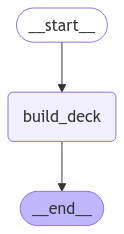

In [43]:
from IPython.display import Image, display

graph = StateGraph(DeckState)
graph.add_node('build_deck', build_deck)
graph.add_edge(START, 'build_deck')
graph.add_edge("build_deck", END)

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [44]:
deck = app.invoke({'prompt': "a black creature-focussed deck built around zombies", 'cards': [], 'n_cards': 0, 'n_lands': 0, 'n_creatures': 0, 'n_other': 0, 'n_enchantments': 0, 'n_instants': 0, 'n_sorceries': 0, 'n_artifacts': 0})

Initial manabase: {'n_black': 2, 'n_black_blue': 0, 'n_black_white': 0, 'n_blue': 0, 'n_blue_white': 0, 'n_green': 1, 'n_green_black': 1, 'n_green_blue': 0, 'n_green_white': 0, 'n_red': 0, 'n_red_black': 0, 'n_red_blue': 0, 'n_red_white': 0, 'n_white': 0}


  0%|          | 0/36 [00:00<?, ?it/s]

Current deck: 
## lands: 4
- 2 x black land: black land
- 1 x green land: green land
- 1 x green_black land: green_black land

## Mana production: green black
## Mana requirements: 

Recommended card:  A strong, black creature with haste that can be played early in the game and provides a good start for your zombie theme.
Matching cards: index 0: **Diregraf Ghoul**: A black 1-mana Zombie creature. It has a power and toughness of 2/2.   **Role & Strengths**: Diregraf Ghoul serves as an early-game zombie token generator, allowing you to create additional threats or resources quickly. Its ability to tap upon entering the battlefield makes it slightly slower in combat but is often offset by its ability to generate tokens.  **Weaknesses**: It enters the battlefield tapped, which can delay its immediate impact on board presence compared to untapped creatures. Additionally, as a 2/2 for only one mana, it's somewhat fragile and may be easily dealt with by stronger opponents if left alone.  Ove

  3%|▎         | 1/36 [00:03<01:49,  3.13s/it]

Selected card index: 4, reason: Death Baron is a strong choice for this deck because it provides significant synergy with other zombies and enhances their power and deathtouch ability. This will strengthen the overall theme of the deck and make it more competitive in the current metagame.
Matching card: {"summary": "**Death Baron**  *Mana Cost: {1}{B}{B}*  **Role & Strengths:**   Death Baron is a Zombie Wizard that provides significant value through its ability, which enhances both Skeletons you control and other Zombies with +1/+1 and deathtouch. This makes it particularly powerful in decks focusing on Zombies or utilizing multiple Skeleton tokens since it effectively increases the power of your creatures and allows them to destroy any creature they deal damage to.  **Weaknesses:**   Despite its strengths, Death Baron is relatively weak as a standalone threat due to its low toughness of 2, making it vulnerable to removal. Additionally, its impact relies heavily on having multiple Zomb

  6%|▌         | 2/36 [00:26<08:40, 15.32s/it]

Failed to correctly select a card after 5 attempts, selecting the zeroth card
Matching card: {"summary": "**Death Baron**  *Mana Cost: {1}{B}{B}*  **Role & Strengths:**   Death Baron is a Zombie Wizard that provides significant value through its ability, which enhances both Skeletons you control and other Zombies with +1/+1 and deathtouch. This makes it particularly powerful in decks focusing on Zombies or utilizing multiple Skeleton tokens since it effectively increases the power of your creatures and allows them to destroy any creature they deal damage to.  **Weaknesses:**   Despite its strengths, Death Baron is relatively weak as a standalone threat due to its low toughness of 2, making it vulnerable to removal. Additionally, its impact relies heavily on having multiple Zombies or Skeletons on the board, which can limit its effectiveness in decks that don't naturally generate them.  Overall, Death Baron excels when integrated into strategies that maximize its ability to buff and lev

  8%|▊         | 3/36 [00:47<09:42, 17.65s/it]

Failed to correctly select a card after 5 attempts, selecting the zeroth card
Matching card: {"summary": "**Death Baron**  *Mana Cost: {1}{B}{B}*  **Role & Strengths:**   Death Baron is a Zombie Wizard that provides significant value through its ability, which enhances both Skeletons you control and other Zombies with +1/+1 and deathtouch. This makes it particularly powerful in decks focusing on Zombies or utilizing multiple Skeleton tokens since it effectively increases the power of your creatures and allows them to destroy any creature they deal damage to.  **Weaknesses:**   Despite its strengths, Death Baron is relatively weak as a standalone threat due to its low toughness of 2, making it vulnerable to removal. Additionally, its impact relies heavily on having multiple Zombies or Skeletons on the board, which can limit its effectiveness in decks that don't naturally generate them.  Overall, Death Baron excels when integrated into strategies that maximize its ability to buff and lev

 11%|█         | 4/36 [01:17<12:01, 22.55s/it]

Failed to correctly select a card after 5 attempts, selecting the zeroth card
Matching card: {"summary": "**Diregraf Ghoul**: A black 1-mana Zombie creature. It has a power and toughness of 2/2.   **Role & Strengths**: Diregraf Ghoul serves as an early-game zombie token generator, allowing you to create additional threats or resources quickly. Its ability to tap upon entering the battlefield makes it slightly slower in combat but is often offset by its ability to generate tokens.  **Weaknesses**: It enters the battlefield tapped, which can delay its immediate impact on board presence compared to untapped creatures. Additionally, as a 2/2 for only one mana, it's somewhat fragile and may be easily dealt with by stronger opponents if left alone.  Overall, Diregraf Ghoul is a strong early-game play that helps bolster zombie tribal decks or those seeking quick board development.", "colors": ["B"], "convertedManaCost": 1, "keywords": null, "manaCost": "{B}", "name": "Diregraf Ghoul", "power"

 14%|█▍        | 5/36 [01:52<13:53, 26.89s/it]

Failed to correctly select a card after 5 attempts, selecting the zeroth card
Matching card: {"summary": "**Crow of Dark Tidings**  *Crow of Dark Tidings* is a black Zombie Bird with flying. It has a moderate mana cost of {2}{B}. Its main role revolves around its mill ability, which triggers when it enters the battlefield or dies, forcing you to put the top two cards of your library into your graveyard.  **Strengths:** - Provides consistent milling, helping thin your deck and increase the chances of drawing your win conditions. - Flying makes it a versatile attacker that can target players or planeswalkers without being blocked by non-flying creatures. - The triggers on both entering and dying make it useful for various strategies, including self-mill or using its death trigger multiple times with cards like *Regrowth*.  **Weaknesses:** - Its low toughness makes it vulnerable to removal spells. - Requires specific deck strategies that benefit from milling or rely on the card's triggere

 14%|█▍        | 5/36 [01:55<11:55, 23.09s/it]


KeyboardInterrupt: 

In [18]:
print(get_deck_list(deck)[1])


## lands: 19
- 4 x black land: black land
- 4 x red land: red land
- 8 x white land: white land
- 1 x Swamp: **Swamp**: A basic land card with no color identity that taps to add one black mana. It plays a foundational role in black-themed decks by providing the necessary mana for casting spells and summoning creatures or enchantments that require black mana. Its strength lies in its simplicity and utility, as it doesn't have any abilities beyond mana generation. However, it's limited to producing only black mana, so you'll need other land types to support additional colors if your deck uses them. Overall, Swamp is a weak but essential component of many black decks.
- 2 x Dismal Backwater: **Dismal Backwater** is a dual land that provides flexibility in your mana base with no color requirement to play. It enters the battlefield tapped but compensates by allowing you to gain 1 life as an added benefit upon entering the battlefield. Its main function is to offer two options: it can produ

In [19]:
deck['n_cards']

60

In [20]:
deck['cards'][-1]

{'name': 'Day of Judgment',
 'types': ['Sorcery'],
 'cost': '{2}{W}{W}',
 'text': 'Destroy all creatures.',
 'power': None,
 'toughness': None,
 'description': "**Day of Judgment**: This is a white sorcery card with a mana cost of {2}{W}{W}, indicating it requires two generic and two white mana to cast. The primary effect is to destroy all creatures on the battlefield, making it a powerful board wipe that can shift control of the game significantly in your favor.   **Strengths**: It's effective at resetting the board state, particularly useful against decks with many creatures or when you're facing an opponent who has amassed numerous threats. Its ability to clear out both your own and your opponent's creatures can be strategically advantageous.  **Weaknesses**: The card does not target, so it cannot selectively remove individual creatures if needed. Additionally, because it destroys all creatures indiscriminately, including those you might want to keep on the battlefield, timing its u

In [ ]:
deck = app.invoke({'prompt': 'blue-white control deck that mills the opponent', 'cards': [], 'n_cards': 0, 'n_lands': 0, 'n_creatures': 0, 'n_other': 0})

In [15]:
def get_response(prompt):
    for step in app.stream(
        {"prompt": "A blue-white control deck"}, stream_mode="updates"
    ):
        print(step)

In [ ]:
get_response("Using the SetsRetriever tool to retrieve valid cards, gradually construct a 60-card deck")